This notebook uses [this blog post](https://medium.com/cloud-to-street/jumpstart-your-machine-learning-satellite-competition-submission-2443b40d0a5a) as a reference.

## Imports

In [1]:
from tqdm.notebook import tqdm
from glob import glob

import os
import sys
import cv2
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
import ttach as tta
import torch.nn as nn
import segmentation_models_pytorch as smp

import warnings
warnings.filterwarnings("ignore")

## Set up paths

In [2]:
# path to dataset root directory
dset_root = '/dli/task/'
test_dir = os.path.join(dset_root, 'test_internal')

n_test_regions = len(glob(test_dir+'/*/'))
print('Number of test temporal-regions: {}'.format(n_test_regions))

Number of test temporal-regions: 14


## Helper functions

In [3]:
def get_test_id(path):
    return path.split("_")[0] + "_" + path.split("_")[1]

def make_im_name(id, suffix):
    return id.split(".")[0] + f"_{suffix}.png"

def s1_to_rgb(vv_image, vh_image):
    ratio_image = np.clip(np.nan_to_num(vh_image/vv_image, 0), 0, 1)
    rgb_image = np.stack((vv_image, vh_image, 1-ratio_image), axis=2)
    return rgb_image

## Create dataframe

As per [the competition website](https://nasa-impact.github.io/etci2021/), the submission file needs to be generated following a particular sequence. 

In [4]:
!wget -q https://git.io/JsRTE -O test_sentinel.csv

In [5]:
test_file_sequence = pd.read_csv("test_sentinel.csv", header=None)
test_file_sequence = test_file_sequence.values.squeeze().tolist()

all_test_vv = [os.path.join(test_dir, get_test_id(id), "tiles", "vv", make_im_name(id, "vv")) 
                                                                for id in test_file_sequence]
all_test_vh = [os.path.join(test_dir, get_test_id(id), "tiles", "vh", make_im_name(id, "vh")) 
                                                                for id in test_file_sequence]

paths = {'vv_image_path': all_test_vv,
         'vh_image_path': all_test_vh,
}

test_df = pd.DataFrame(paths)
print(test_df.shape)

(12348, 2)


## Dataset

In [6]:
class ETCIDataset(Dataset):
    def __init__(self, dataframe, split, transform=None):
        self.split = split
        self.dataset = dataframe
        self.transform = transform

    def __len__(self):
        return self.dataset.shape[0]


    def __getitem__(self, index):
        example = {}
        
        df_row = self.dataset.iloc[index]

        # load vv and vh images
        vv_image = cv2.imread(df_row['vv_image_path'], 0) / 255.0
        vh_image = cv2.imread(df_row['vh_image_path'], 0) / 255.0
        
        # convert vv and ch images to rgb
        rgb_image = s1_to_rgb(vv_image, vh_image)

        if self.split == 'test':
            # no flood mask should be available
            example['image'] = rgb_image.transpose((2,0,1)).astype('float32')
        else:
            # load ground truth flood mask
            flood_mask = cv2.imread(df_row['flood_label_path'], 0) / 255.0

            # compute transformations
            if self.transform:
                augmented = self.transform(image=rgb_image, mask=flood_mask)
                rgb_image = augmented['image']
                flood_mask = augmented['mask']

            example['image'] = rgb_image.transpose((2,0,1)).astype('float32')
            example['mask'] = flood_mask.astype('int64')

        return example

In [7]:
test_dataset = ETCIDataset(test_df, split='test', transform=None)

batch_size = 96 * torch.cuda.device_count()
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                         num_workers=os.cpu_count(), pin_memory=True)

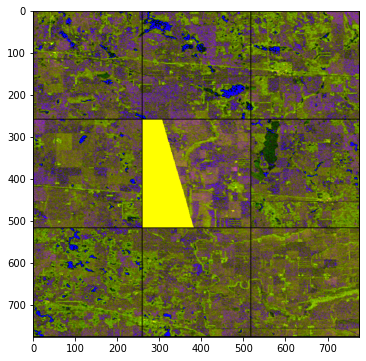

In [8]:
def matplotlib_imshow(img, one_channel=False):
    fig,ax = plt.subplots(figsize=(10, 6))
    ax.imshow(img.permute(1,2,0).numpy())

images = next(iter(test_loader))['image']

img_grid = torchvision.utils.make_grid(images[50:59], nrow=3, normalize=False)
matplotlib_imshow(img_grid)

## Ensembling

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
def get_predictions_single(model_def, weights):
    model_def.load_state_dict(torch.load(weights))
    model = tta.SegmentationTTAWrapper(model_def, tta.aliases.d4_transform(), merge_mode='mean') # mean yields the best results
    model.to(device)

    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)

    final_predictions = []

    model.eval()
    with torch.no_grad():
        for batch in tqdm(test_loader):
            # load image and mask into device memory
            image = batch['image'].to(device)

            # pass images into model
            pred = model(image)

            # add to final predictions
            final_predictions.append(pred.detach().cpu().numpy())

    final_predictions = np.concatenate(final_predictions, axis=0)
    
    return final_predictions

**Note** that here we are defining two model classes and then we are loading the pre-trained weights into them. These weights were obtained using the `src/train.py` script. You can plug in other models (and you should) here to construct your ensemble. 

In [11]:
unet_mobilenet = smp.Unet(
    encoder_name="mobilenet_v2", 
    encoder_weights=None, 
    in_channels=3,                  
    classes=2                      
)

upp_mobilenet = smp.UnetPlusPlus(
    encoder_name="mobilenet_v2", 
    encoder_weights=None, 
    in_channels=3,                  
    classes=2                      
)

model_defs = [unet_mobilenet, upp_mobilenet]

In [12]:
model_paths = ["Best_IoU/unet_mobilenet_v2_0.pth",
              "Best_IoU/upp_mobilenetv2_0.pth"]

In [ ]:
all_preds = []

for defi, path in zip(model_defs, model_paths):
    all_preds.append(get_predictions_single(defi, path))
    
all_preds = np.array(all_preds)
all_preds = np.mean(all_preds, axis=0)
class_preds = all_preds.argmax(axis=1).astype('uint8')

save_path = 'submission.npy'
np.save(save_path, class_preds, fix_imports=True, allow_pickle=False)